In [1250]:
from PIL import Image
from pathlib import Path
from skimage import measure
import numpy as np
import re
import ntpath
import random
from copy import deepcopy
import tqdm

In [1251]:
class imclass:
    def __init__(self,id,im_list,mask_list,total_area):
        self.classid = id
        self.area = total_area
        self.im_list = im_list
        self.mask_list = mask_list

In [1252]:
#a class with image and its area (minus black background)
#class id
class im:
    def __init__(self,img,area,obj):
        self.img= img
        self.area = area
        self.obj =  obj


In [1253]:
#todo:add class id and track area of each class
#add maximum overlapp\
import builtins
range = builtins.range

In [1254]:
iter_order = [2,10,5,4,6,11,7,9,8,12,3,1]

In [1255]:
#read crops from folder
folder_dir = Path(r'\\fatherserverdw\kyuex\great\mask and crop\2022-06-07 13.51.05imcrop')

class_im_list=[[] for i in range(13)]

for path in folder_dir.glob('*.png'):
    image = Image.open(path)
    objid= re.findall("obj(\d+).png", ntpath.basename(path))
    image_arr = np.array(image) #change image into a numpy array?
    area = np.sum(image_arr>0) #get the area of image minus black background\
    im_obj = im(image,area,objid) #create an image object

    classid = re.findall("class(\d+)_", ntpath.basename(path))[0]

    class_im_list[int(classid)].append(im_obj)

In [1256]:
folder_mask_dir = Path(r'\\fatherserverdw\kyuex\great\mask and crop\2022-06-07 13.51.05mskcrop')
#we won't use class_list[0]
class_mask_list=[[] for i in range(13)]

for path in folder_mask_dir.glob('*.png'):
    image = Image.open(path)
    objid= re.findall("obj(\d+).png", ntpath.basename(path))
    image_arr = np.array(image) #change image into a numpy array?
    area = np.sum(image_arr>0) #get the area of image minus black background\
    im_obj = im(image,area,objid) #create an image object

    classid = re.findall("classnew(\d+)_", ntpath.basename(path))[0]

    class_mask_list[int(classid)].append(im_obj)

In [1257]:
classobj_list=[]
for id in iter_order:
    classobj_list.append(imclass(id,class_im_list[id],class_mask_list[id],0))

In [1258]:
#80% of the image will be filled
#create blank image for collage
DLinputsz = (1024,1024) #dimension of collage

background_ratio = 0.8
collage_area = DLinputsz[0]* DLinputsz[1] * background_ratio #this is a floa

#maximum overlapping between annotations, TODO
max_overlapping_area= 500

num_class = 12 #there are 12 classes
class_area = collage_area / num_class #float: the area each class should occupy
class_threshold = 20; # you can exceed class area by 20

#loop through classes and randomly pick from a class\
#track area for each class

In [1259]:
for i in range(1,11):
    filled_area = 0

    imgblank= Image.new(mode="RGB",size=DLinputsz)
    maskblank = Image.new(mode="L",size=DLinputsz)
    classblank = Image.new(mode="L",size=DLinputsz)

    #create random generator
    random.seed()

    while(filled_area < collage_area):
        for classobj in classobj_list:
            r = len(classobj.im_list)
            # this is looping through the classobj_list again and again,
            # if you change "if" to "while", then it's looping through one class at a time
            if(classobj.area < class_area):
                #pick random images from this class and paste
                idx = random.randint(0, r-1)
                print(str(classobj.classid) + ","+ str(idx))
                im = classobj.im_list[idx]
                mask = classobj.mask_list[idx]

                #TODO: maximum overlay
                #1.create a mask image,then subtract the two masks and get difference
                #if difference greater then max_overlay, then need to recalculate

                binary_mask = np.array(mask.img)
                binary_mask[binary_mask > 0] = 1
                old_mask = maskblank.copy()

                test_mask = maskblank.copy()
                #is this right?
                free_region_index = np.argwhere(np.array(maskblank)==0)
                xy = random.randint(0,len(free_region_index)-1)
                xycoord = tuple(free_region_index[xy])
                #check overlay
                overlay = np.sum(binary_mask) - np.sum(np.array(test_mask)- np.array(old_mask))

                #if too much overlapping, adjust xycoord
                #TODO: move on to the next one if it gets stuck too long

                #introduce new object to compiling tile
                attempt = 0
                max_overlapping_area= 500
                while(overlay > max_overlapping_area):

                    test_mask = maskblank.copy()
                    #randomly choose where to place excluding the filled area
                    # xycoord = (random.randint(0, DLinputsz[0]), random.randint(0, DLinputsz[1])) #create tuple of x,y coordinates to place on collage
                    xy = random.randint(0,len(free_region_index))
                    xycoord = tuple(free_region_index[xy])
                    #place object
                    test_mask.paste(Image.fromarray(binary_mask),xycoord,mask=Image.fromarray((np.array(binary_mask).astype('bool')*255)).convert('L'))
                    #check overlay: area of new object - area of potentially overlapping object in existing tile
                    overlay = np.sum(binary_mask) - np.sum(np.array(test_mask) - np.array(old_mask))
                    attempt += 1
                    if attempt > 10:
                        max_overlapping_area += 100

                maskblank.paste(Image.fromarray(binary_mask),xycoord,mask=Image.fromarray((np.array(binary_mask).astype('bool')*255)).convert('L'))
                imgblank.paste(im.img, xycoord, mask=Image.fromarray((np.array(mask.img).astype('bool')*255)).convert('L'))
                classblank.paste(mask.img,xycoord, mask=Image.fromarray((np.array(mask.img).astype('bool')*255)).convert('L'))
                #TODO: need to subtract area that is out of bounds

                cropped_area = np.sum(binary_mask) - overlay

                classobj.area = classobj.area + cropped_area

                #this filled area disgardes the area of overlapping, if want exact filled area, it's np.sum(maskblank)
                filled_area = filled_area + cropped_area
                #if we use the exact filled area, the classobj.area will be filled while the filled_area will not be filled
                #and the looop will run forever
                filled_area = np.sum(maskblank)

    imgblank.save(r'\\fatherserverdw\kyuex\great\tiles\2022-06-07 13.51.05-obj{}.png'.format(i))
    classblank.save(r'\\fatherserverdw\kyuex\great\tiles\2022-06-07 13.51.05-mask{}.png'.format(i))
    #reset area to 0
    for classobj in classobj_list:
        classobj.area = 0


2,1
10,2
5,4
4,3
6,0
11,16
7,4
9,7
8,0
12,7
3,1
1,10
2,4
10,3
5,9
4,2
6,0
11,1
7,9
9,9
8,3
12,9
3,1
1,17
2,7
10,3
5,4
4,3
6,0
11,6
7,4
9,0
8,1
12,2
3,1
1,2
2,1
10,3
5,8
4,2
6,0
11,1
7,2
9,15
8,16
12,1
3,0
1,13
2,7
10,2
5,11
4,1
6,0
11,12
7,17
9,16
8,3
12,5
3,1
1,18
2,7
10,2
5,9
4,0
6,0
11,1
7,5
9,2
8,7
12,8
3,1
1,16
2,0
10,3
5,0
4,0
6,0
11,13
7,16
9,3
8,9
12,7
3,1
1,15
2,0
10,3
5,7
4,0
6,0
11,6
7,12
9,8
8,9
12,9
3,0
1,1
2,3
10,3
5,3
4,2
6,0
11,11
7,15
9,8
8,7
12,7
3,1
1,16
2,6
10,2
5,9
4,3
6,0
11,4
7,18
9,15
8,4
12,4
3,1
1,17
2,6
10,1
5,6
4,3
6,0
11,1
7,5
9,2
8,4
12,1
3,0
1,5
2,4
10,2
5,4
4,0
6,0
11,7
7,3
9,0
8,7
12,3
3,1
1,0
2,7
10,0
5,5
4,0
6,0
11,10
7,6
9,9
8,11
12,0
3,0
1,10
2,1
10,2
5,11
4,3
6,0
11,0
7,8
9,1
8,10
12,9
3,1
1,19
2,0
10,2
5,7
4,0
6,0
11,11
7,16
9,9
8,13
12,4
3,1
1,16
2,3
10,1
5,1
6,0
11,14
7,15
9,17
8,8
3,0
1,11
2,3
10,2
5,9
11,6
7,2
9,1
8,11
3,1
1,5
2,0
10,1
5,6
11,0
7,18
9,17
8,2
3,0
1,19
2,5
10,3
5,1
11,19
7,15
9,10
8,15
3,1
1,2
2,0
10,2
5,10
11,5
7,19
9,15
8,5
3,

C:\Users\kyuha\AppData\Local\Temp\ipykernel_21184\397346801.py:37: RuntimeWarning: overflow encountered in ulong_scalars
  overlay = np.sum(binary_mask) - np.sum(np.array(test_mask)- np.array(old_mask))
C:\Users\kyuha\AppData\Local\Temp\ipykernel_21184\397346801.py:55: RuntimeWarning: overflow encountered in ulong_scalars
  overlay = np.sum(binary_mask) - np.sum(np.array(test_mask) - np.array(old_mask))


10,2
9,17
8,13
10,3
9,16
8,13
10,3
9,8
8,11
10,0
9,12
8,10
10,0
9,16
8,2
10,3
9,18
8,9
10,0
9,1
8,8
10,2
9,18
8,13
10,0
9,12
8,4
10,0
9,10
8,2
10,0
9,17
8,7
10,1
9,3
8,7
10,0
9,9
8,5
10,0
9,18
8,5
10,3
9,12
8,6
10,0
9,11
8,0
10,3
9,11
8,3
10,1
9,4
8,3
10,0
9,12
8,16
10,1
9,13
8,5
10,1
9,11
8,15
10,1
9,10
8,7
10,2
9,13
8,16
10,0
9,13
8,12
10,0
9,5
8,5
10,3
9,16
8,11
10,0
9,1
8,6
10,1
9,1
8,8
10,3
9,8
8,0
10,2
9,18
8,4
10,3
9,0
8,7
10,2
9,12
8,2
10,3
9,12
8,3
10,2
9,7
8,6
10,1
9,4
8,8
10,3
9,0
8,13
10,2
9,17
8,16
10,2
9,2
8,7
10,3
9,10
8,4
10,1
9,18
8,1
10,3
9,11
8,3
10,3
9,6
8,12
10,3
9,8
8,10
10,2
9,1
8,9
10,0
9,4
8,10
10,3
9,15
8,16
10,1
9,5
8,1
10,2
8,9
10,1
8,0
10,2
8,3
10,0
8,5
10,1
8,15
10,0
8,16
10,3
8,14
10,1
8,14
10,1
8,14
10,3
8,10
10,3
8,12
10,1
8,11
10,3
8,9
10,3
8,15
10,2
8,0
10,3
8,1
10,0
8,2
10,0
8,4
10,2
8,8
10,2
8,14
10,0
8,1
10,0
8,13
10,2
8,7
10,0
8,14
10,3
8,12
10,3
8,15
10,2
8,7
10,2
8,6
10,1
8,1
10,3
8,5
10,3
8,10
10,0
8,4
10,0
8,15
10,0
8,1
10,2
8,5
10,2
8,11
10,2

In [1239]:
classobj.classid

6

In [ ]:
imgblank.show()

In [1194]:
len(free_region_index)

283511

In [1192]:
xy

283511

In [1193]:
free_region_index[xy]

IndexError: index 283511 is out of bounds for axis 0 with size 283511

In [1180]:
free_region_index

array([], shape=(0, 2), dtype=int64)

In [ ]:
   #NOTE: i am not sure if this works, i am making pixels that are out of bounds zero
            #then cropped_area is the sum of pixels in arr_copy that is greater than zero

                if(max_x <  num_cols): #check if part of the img is out of bounds
                    for i in range (max_x,num_cols-1): #clear columns (x)
                        arr_copy[i] = 0

                if(max_y <  num_rows):
                    for i in range (max_y,num_rows-1): #clear rows (y)
                        arr_copy[:i] = 0

            #find max row and column of arr_copy
                copy_img = deepcopy(im.img)
                arr_copy = np.array(copy_img)
                num_rows = arr_copy.shape[1]
                num_cols = arr_copy.shape[0]


                cropped_area = np.sum(arr_copy>0)


                print(cropped_area)

In [ ]:

            max_x = (DLinputsz[0] - xycoord[0])
            max_y= DLinputsz[1] - xycoord[1]

            #find max row and column of arr_copy
            copy_img = deepcopy(im.img)
            arr_copy = np.array(copy_img)
            num_rows = arr_copy.shape[1]
            num_cols = arr_copy.shape[0]


            #NOTE: i am not sure if this works, i am making pixels that are out of bounds zero
            #then cropped_area is the sum of pixels in arr_copy that is greater than zero

            if(max_x <  num_cols): #check if part of the img is out of bounds
                for i in range (max_x,num_cols-1): #clear columns (x)
                    arr_copy[i] = 0

            if(max_y <  num_rows):
                for i in range (max_y,num_rows-1): #clear rows (y)
                    arr_copy[:i] = 0

            cropped_area = np.sum(arr_copy>0)

            #update filled_area and image total area
            classobj.area = classobj.area + cropped_area




In [48]:
#create a list of im class to store: (image array, area, classid, objid)
im_list=list()
obj_num = 0 #number of objects in the class

for path in pathes:
    obj_num = obj_num + 1 #increment number of objects
    image = Image.open(path)
    objid= re.findall("obj(\d+).png", ntpath.basename(path))
    classid = re.findall("class(\d+)_", ntpath.basename(path))
    image_arr = np.array(image) #change image into a numpy array?
    area = np.sum(image_arr>0) #get the area of image minus black background\

    im_list.append(im(image,area,objid, 0,classid)) #add to the list of im classes


#the maximum area each object type could occupy
max_obj_area = collage_area / obj_num




In [49]:
#create a list of masks
mask_list = list()
for path in mask_pathes:
    image = Image.open(path)
    objid= re.findall("obj(\d+).png", ntpath.basename(path))
    classid = re.findall("class(\d+)_", ntpath.basename(path))
    image_arr = np.array(image)
    mask_list.append(im(image,0,objid, 0,classid)) #don't need area


In [50]:
#add collage to image, need to track filled_area
#need to track each class' area (need to loop through entire list, find same class ID and update total_area)

#Question: change the x,y coord of image to the center? (so that it could cut off the edge) ??

while(filled_area <= collage_area):
    #loop through im_list
    #TODO: check overlapping (need to keep track of which pixels are set)
    for im,mask in zip(im_list,mask_list):
        #if total_area hasn't exceeded designated area for each class
        while(im.total_area <= max_obj_area):
            xycoord = (random.randint(0, DLinputsz[0]), random.randint(0, DLinputsz[1])) #create tuple of x,y coordinates to place on collage
            imgblank.paste(im.img, xycoord, mask=Image.fromarray((np.array(mask.img).astype('bool')*255)).convert('L')) #paste im onto imgblank, xy coord is the upper left corner of im

            #----update areas here----

            #TODO: exclude area that is out of bounds
            #which row and colum to delete

            max_x = (DLinputsz[0] - xycoord[0])
            max_y= DLinputsz[1] - xycoord[1]

            #find max row and column of arr_copy
            copy_img = deepcopy(im.img)
            arr_copy = np.array(copy_img)
            num_rows = arr_copy.shape[1]
            num_cols = arr_copy.shape[0]


            #NOTE: i am not sure if this works, i am making pixels that are out of bounds zero
            #then cropped_area is the sum of pixels in arr_copy that is greater than zero

            if(max_x <  num_cols): #check if part of the img is out of bounds
                for i in range (max_x,num_cols-1): #clear columns (x)
                    arr_copy[i] = 0

            if(max_y <  num_rows):
                for i in range (max_y,num_rows-1): #clear rows (y)
                    arr_copy[:i] = 0

            cropped_area = np.sum(arr_copy>0)



            #update filled_area and image total area
            filled_area = filled_area + cropped_area

            #TODO: if there is more than one object in a class, need to loop through all the objects in that class
            #and update the total_area
            #class_list = [x for x in im_list if x.classid == im.classid]
            id = im.classid
            for image in im_list:
                if image.classid == id:
                    image.total_area = image.total_area + cropped_area  #used to be img.area


#display collage
imgblank.show()


KeyboardInterrupt: 

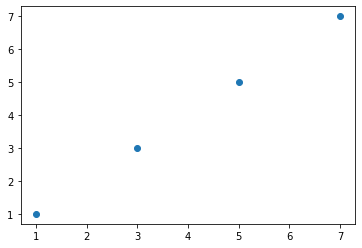

In [18]:
from matplotlib import pyplot as plt
plt.scatter([1,3,5,7],[1,3,5,7])

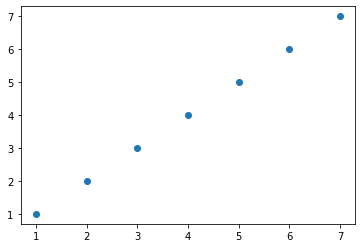

In [20]:
plt.scatter([1,2,3,4,5,6,7],[1,2,3,4,5,6,7])